In [ ]:
# Install Pytorch
%pip install "torch==2.2.2" tensorboard

# Install Hugging Face libraries
%pip install --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"

%pip install --upgrade transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manyl

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


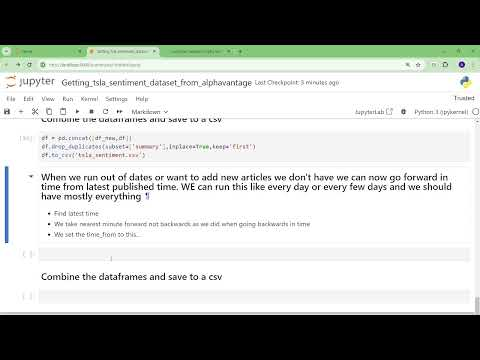

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('ascf3y7zSaY')

In [ ]:
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


In [ ]:
df = pd.read_csv("twitter_8000_etiketlenmis.csv")
df

,clean_text,sentiment
0,ömürboyu borçlu mazlum müslüman müebbet nafaka...,Negative
1,mayısta türkiye sizi tarihin çöplüğüne gömecek,Negative
2,meb öğrenim özrü haric herşeyi düsünüyor bizid...,Negative
3,reis yürü millet yürüsün arkandan,Positive
4,yazik istedigi gibi oynatiyor oynamaya merakli...,Negative
...,...,...
7918,bu devlet zalime karşı acımasız mazluma karşı ...,Positive
7919,yaşasin hukukuk üstünlüğünü çünkü hukuk üstü i...,Positive
7920,mensubu bazı milletvekillerinin kürt halkı yer...,Neutral
7921,her şey seyredildiği gibi isitde seyredildi se...,Positive


**Sentiment** kısmı **string** olduğundan modelimiz için anlamlı değildir o yüzden onu anlamlı number lara atıyoruz.

In [ ]:
df['sentiment']=df['sentiment'].astype('category')
df['target']=df['sentiment'].cat.codes

df.head()

,clean_text,sentiment,target
0,ömürboyu borçlu mazlum müslüman müebbet nafaka...,Negative,0
1,mayısta türkiye sizi tarihin çöplüğüne gömecek,Negative,0
2,meb öğrenim özrü haric herşeyi düsünüyor bizid...,Negative,0
3,reis yürü millet yürüsün arkandan,Positive,2
4,yazik istedigi gibi oynatiyor oynamaya merakli...,Negative,0


In [ ]:
df['sentiment'].cat.categories

Index(['Negative', 'Neutral', 'Positive'], dtype='object')

In [ ]:
category_map = {code: category for code, category in enumerate(df['sentiment'].cat.categories)}
category_map

{0: 'Negative', 1: 'Neutral', 2: 'Positive'}

In [ ]:
train_end_point = int(df.shape[0]*0.6)
val_end_point = int(df.shape[0]*0.8)
df_train = df.iloc[:train_end_point,:]
df_val = df.iloc[train_end_point:val_end_point,:]
df_test = df.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)

(4753, 3) (1585, 3) (1585, 3)


In [ ]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
dataset_train = Dataset.from_pandas(df_train.drop('sentiment',axis=1))
dataset_val = Dataset.from_pandas(df_val.drop('sentiment',axis=1))
dataset_test = Dataset.from_pandas(df_test.drop('sentiment',axis=1))

In [ ]:
#shuffle
dataset_train_shuffled = dataset_train.shuffle(seed=23)  # Using a seed for reproducibility

In [ ]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['clean_text', 'target'],
        num_rows: 4753
    })
    val: Dataset({
        features: ['clean_text', 'target'],
        num_rows: 1585
    })
    test: Dataset({
        features: ['clean_text', 'target'],
        num_rows: 1585
    })
})

In [ ]:
dataset['train']

Dataset({
    features: ['clean_text', 'target'],
    num_rows: 4753
})

In [ ]:
df_train.target.value_counts(normalize=True)

,proportion
target,
0,0.619609
2,0.233326
1,0.147065


In [ ]:
class_weights=(1/df_train.target.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights

tensor([0.1271, 0.5354, 0.3375])

**LOAD** **LLAMA** with 4 bit quantization


In [ ]:
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

In [ ]:
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=3
)

model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3.1-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNor

In [ ]:
model = prepare_model_for_kbit_training(model)
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNor

In [ ]:
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
        

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

In [ ]:
df_test

,clean_text,sentiment,target
6338,sayın başkanım ogm hizmet alımı tırmık ekibind...,Neutral,1
6339,siha ve ihalara bedelli askerlik ile destek se...,Positive,2
6340,tebrikler çok başarımı bir çalışma,Positive,2
6341,özel eğitim kurumuna giden öğretmen ve öğrenci...,Neutral,1
6342,bizlerde tıpkı öğretmen polis hemşire doktor g...,Neutral,1
...,...,...,...
7918,bu devlet zalime karşı acımasız mazluma karşı ...,Positive,2
7919,yaşasin hukukuk üstünlüğünü çünkü hukuk üstü i...,Positive,2
7920,mensubu bazı milletvekillerinin kürt halkı yer...,Neutral,1
7921,her şey seyredildiği gibi isitde seyredildi se...,Positive,2


In [ ]:
sentences = df_test.clean_text.tolist()
sentences[0:2]

['sayın başkanım ogm hizmet alımı tırmık ekibinde kadro de kapsasın hizmet alımı ogm tırmık ekibi kadro istiyor',
 'siha ve ihalara bedelli askerlik ile destek seçim öncesi bedelli askerlik bekliyoruz akpden']

In [ ]:
# Convert summaries to a list
sentences = df_test.clean_text.tolist()

# Define the batch size
batch_size = 32  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs = []

# Process the sentences in batches
for i in range(0, len(sentences), batch_size):
    # Get the batch of sentences
    batch_sentences = sentences[i:i + batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])

In [ ]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs

tensor([[ 2.4656, -2.5631,  1.5232],
        [ 1.6140, -2.9464,  3.7702],
        [ 3.6806, -3.3365,  3.4961],
        ...,
        [ 2.1632, -1.7445,  2.3239],
        [ 3.3795, -1.1465,  4.8421],
        [ 2.8657, -2.7467,  4.6470]], device='cuda:0')

In [ ]:
final_outputs.argmax(axis=1)

tensor([0, 2, 0,  ..., 2, 2, 2], device='cuda:0')

In [ ]:
df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
df_test['predictions']

<ipython-input-28-7c1d2547ae19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()


,predictions
6338,0
6339,2
6340,0
6341,2
6342,2
...,...
7918,2
7919,0
7920,2
7921,2


In [ ]:
df_test['predictions'].value_counts()

,count
predictions,
2,1066
0,509
1,10


In [ ]:
df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])
df_test['predictions']

<ipython-input-30-b56fb9d5a919>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


,predictions
6338,Negative
6339,Positive
6340,Negative
6341,Positive
6342,Positive
...,...
7918,Positive
7919,Negative
7920,Positive
7921,Positive


In [ ]:
def get_performance_metrics(df_test):
  y_test = df_test.sentiment
  y_pred = df_test.predictions

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [ ]:
get_performance_metrics(df_test)

Confusion Matrix:
[[  0   0   0]
 [160   5 447]
 [349   5 619]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         0
     Neutral       0.50      0.01      0.02       612
    Positive       0.58      0.64      0.61       973

    accuracy                           0.39      1585
   macro avg       0.36      0.21      0.21      1585
weighted avg       0.55      0.39      0.38      1585

Balanced Accuracy Score: 0.3221733537539716
Accuracy Score: 0.3936908517350158


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWar

In [ ]:
df_test

,clean_text,sentiment,target,predictions
6338,sayın başkanım ogm hizmet alımı tırmık ekibind...,Neutral,1,Negative
6339,siha ve ihalara bedelli askerlik ile destek se...,Positive,2,Positive
6340,tebrikler çok başarımı bir çalışma,Positive,2,Negative
6341,özel eğitim kurumuna giden öğretmen ve öğrenci...,Neutral,1,Positive
6342,bizlerde tıpkı öğretmen polis hemşire doktor g...,Neutral,1,Positive
...,...,...,...,...
7918,bu devlet zalime karşı acımasız mazluma karşı ...,Positive,2,Positive
7919,yaşasin hukukuk üstünlüğünü çünkü hukuk üstü i...,Positive,2,Negative
7920,mensubu bazı milletvekillerinin kürt halkı yer...,Neutral,1,Positive
7921,her şey seyredildiği gibi isitde seyredildi se...,Positive,2,Positive


In [ ]:
MAX_LEN = 512
col_to_delete = ['clean_text']

def llama_preprocessing_function(examples):
    return tokenizer(examples['clean_text'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets = tokenized_datasets.rename_column("target", "label")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/4753 [00:00<?, ? examples/s]

Map:   0%|          | 0/1585 [00:00<?, ? examples/s]

Map:   0%|          | 0/1585 [00:00<?, ? examples/s]

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}


In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir = 'sentiment_classification',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 2,
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
)

<ipython-input-37-1bea759fa04e>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


In [ ]:
train_result = trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
1,0.879600,0.466845,0.580407,0.813249
2,0.521400,0.461927,0.598242,0.837224


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [ ]:
def make_predictions(model,df_test):


  # Convert summaries to a list
  sentences = df_test.clean_text.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(sentences), batch_size):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


make_predictions(model,df_test)

<ipython-input-42-311dd4a73c9e>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
<ipython-input-42-311dd4a73c9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


In [ ]:
get_performance_metrics(df_test)

Confusion Matrix:
[[  0   0   0]
 [ 73 451  88]
 [ 66  68 839]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         0
     Neutral       0.87      0.74      0.80       612
    Positive       0.91      0.86      0.88       973

    accuracy                           0.81      1585
   macro avg       0.59      0.53      0.56      1585
weighted avg       0.89      0.81      0.85      1585

Balanced Accuracy Score: 0.7996048539319804
Accuracy Score: 0.8138801261829653


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWar

In [ ]:
metrics = train_result.metrics
max_train_samples = len(dataset_train)
metrics["train_samples"] = min(max_train_samples, len(dataset_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        2.0
  total_flos               = 23470515GF
  train_loss               =     0.6634
  train_runtime            = 1:17:55.24
  train_samples            =       4753
  train_samples_per_second =      2.033
  train_steps_per_second   =      0.255


In [ ]:
trainer.save_model("saved_model")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [71]:
!git config --global user.name "keremyvnc"
!git config --global user.email "keryuvanc@gmail.com"


In [94]:
!git clone https://github.com/keremyvnc/TextClassifitonUsingLLama.git

Cloning into 'TextClassifitonUsingLLama'...


In [95]:
model.save_pretrained('/content/textClassificationWithLLama/model')

In [96]:
tokenizer.save_pretrained('/content/textClassificationWithLLama/tokenizer')

('/content/textClassificationWithLLama/tokenizer/tokenizer_config.json',
 '/content/textClassificationWithLLama/tokenizer/special_tokens_map.json',
 '/content/textClassificationWithLLama/tokenizer/tokenizer.json')